Récupération des données pour KBE via stooq...
Données téléchargées : 755 jours de trading.
Fichier sauvegardé : ../data/financial_data_KBE.csv


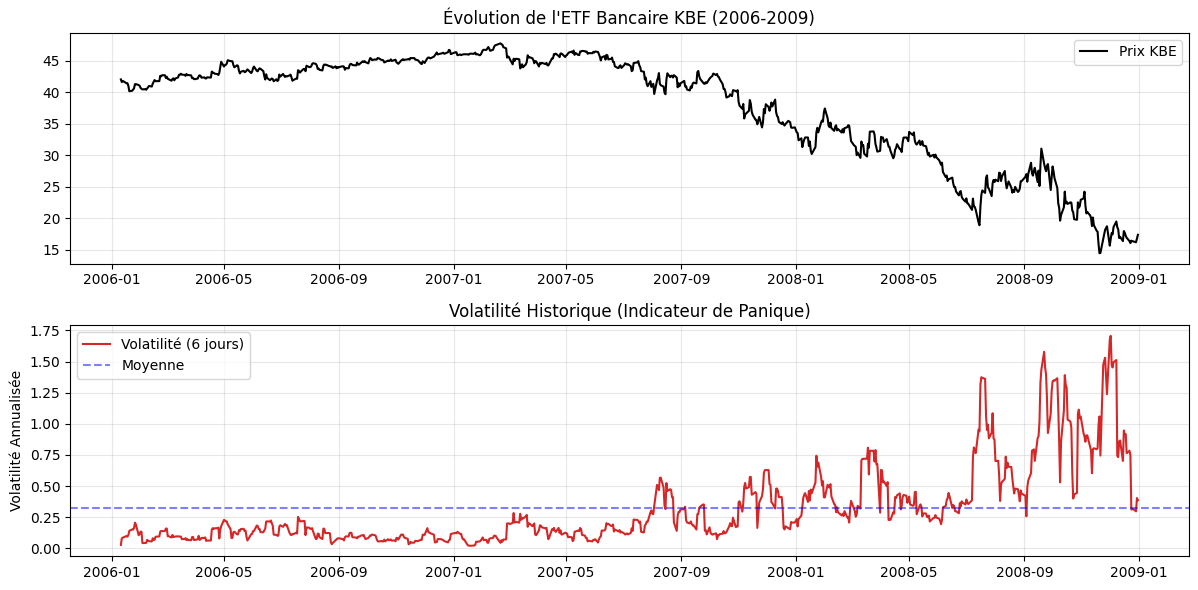

In [19]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
TICKER = 'KBE'       # SPDR S&P Bank ETF (Proxy banques régionales)
SOURCE = 'stooq'     # Plus fiable que Yahoo
START_DATE = '2006-01-01'
END_DATE = '2009-01-01'

# Le paramètre "Magique" trouvé lors de nos tests
# 6 jours = Compromis idéal pour capter la réactivité (Lag 1) et la tendance (Lag 15)
VOL_WINDOW = 6 

OUTPUT_DIR = '../data'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'financial_data_KBE.csv')

# --- 1. TÉLÉCHARGEMENT ---
print(f"Récupération des données pour {TICKER} via {SOURCE}...")
try:
    df = web.DataReader(TICKER, SOURCE, start=START_DATE, end=END_DATE).sort_index()
    print(f"Données téléchargées : {len(df)} jours de trading.")

    # --- 2. CALCULS FINANCIERS ---
    # A. Rendements Logarithmiques : ln(Pt / Pt-1)
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

    # B. Volatilité Historique (Annualisée)
    df['Volatility'] = df['Log_Ret'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)

    # --- 3. NETTOYAGE & SAUVEGARDE ---
    df_clean = df.dropna().copy()
    
    # On ne garde que l'essentiel
    df_final = df_clean[['Close', 'Volatility']]
    df_final.index.name = 'Date' # Standardisation
    
    # Création dossier si inexistant
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    df_final.to_csv(OUTPUT_FILE)
    print(f"Fichier sauvegardé : {OUTPUT_FILE}")

    # --- 4. VISUALISATION ---
    plt.figure(figsize=(12, 6))
    
    # Sous-graphe 1 : Prix
    plt.subplot(2, 1, 1)
    plt.plot(df_final.index, df_final['Close'], color='black', label='Prix KBE')
    plt.title(f"Évolution de l'ETF Bancaire {TICKER} (2006-2009)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Sous-graphe 2 : Volatilité
    plt.subplot(2, 1, 2)
    plt.plot(df_final.index, df_final['Volatility'], color='#d62728', label=f'Volatilité ({VOL_WINDOW} jours)')
    plt.title("Volatilité Historique (Indicateur de Panique)")
    plt.axhline(df_final['Volatility'].mean(), color='blue', linestyle='--', alpha=0.5, label='Moyenne')
    plt.ylabel("Volatilité Annualisée")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erreur Critique : {e}")

Colonnes Sentiment : Index(['date_only', 'mean', 'count'], dtype='object')
Colonnes Finance : Index(['Date', 'Close', 'Volatility'], dtype='object')


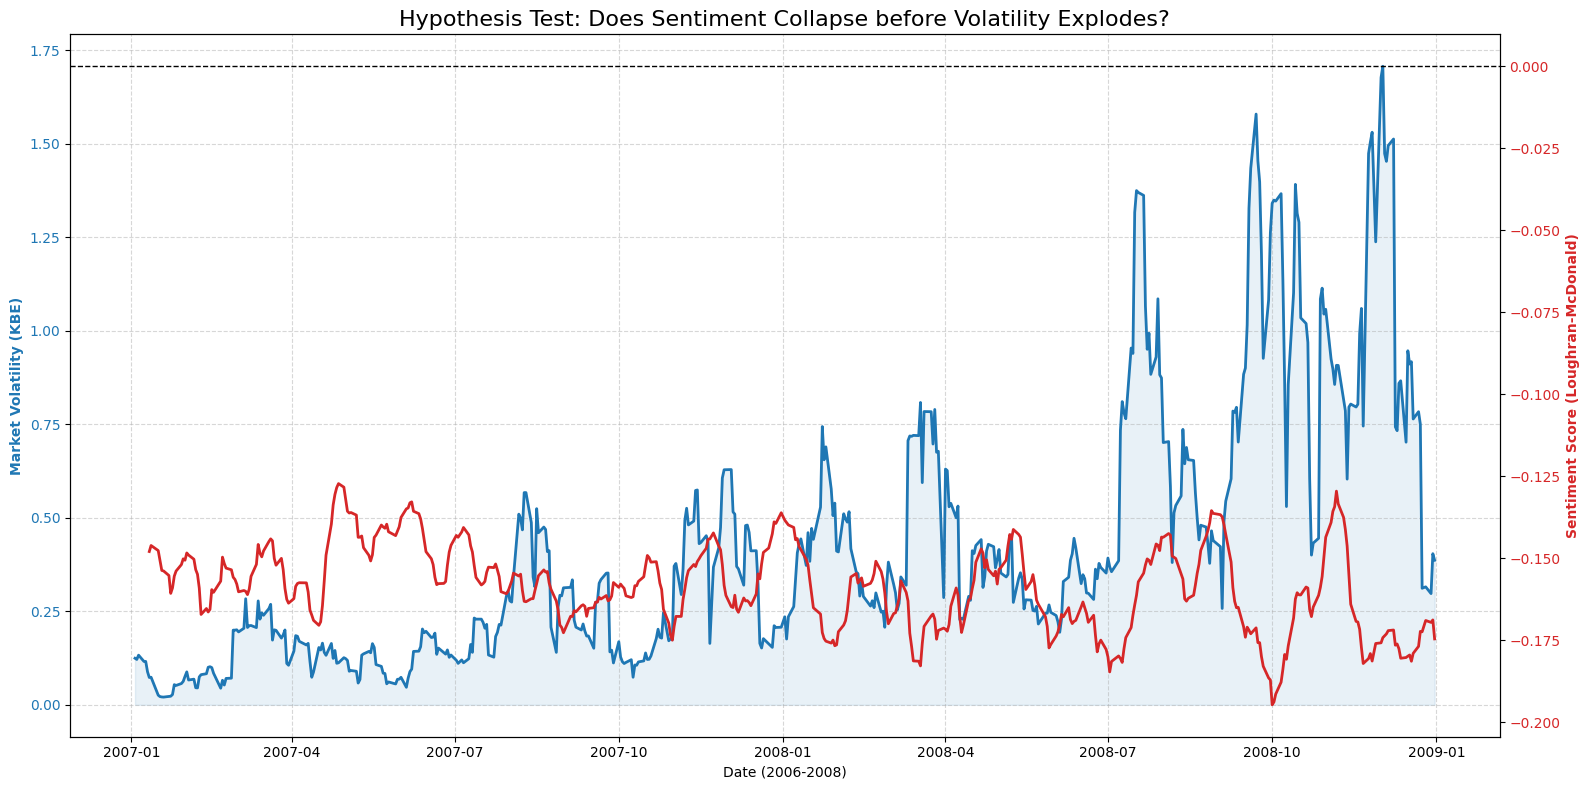

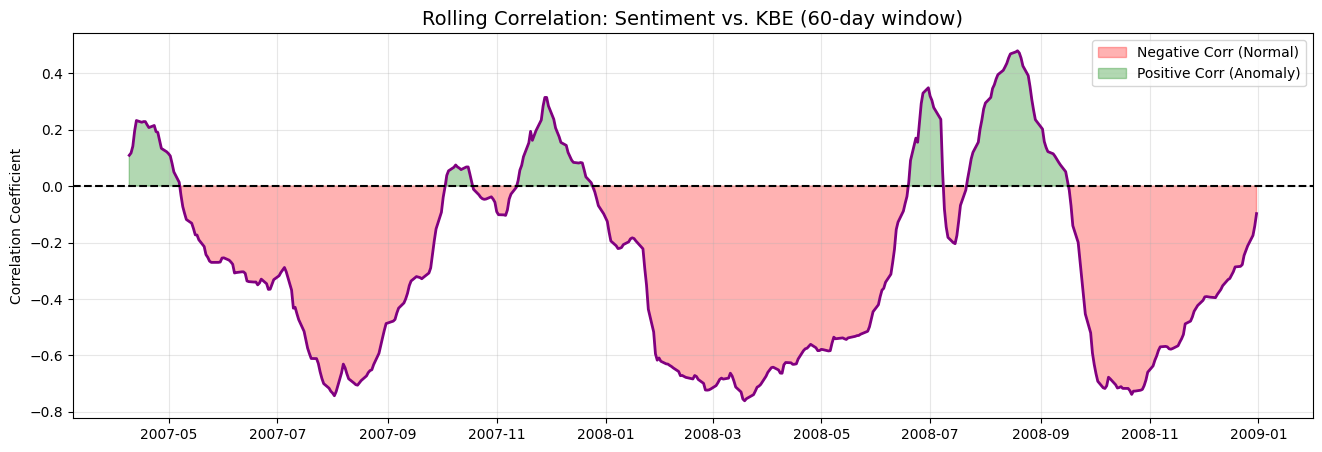

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Chargement des données
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_fine = pd.read_csv('../data/financial_data_KBE.csv') 

# --- DEBUG : AFFICHE LES COLONNES POUR ÊTRE SÛR ---
print("Colonnes Sentiment :", df_sent.columns)
print("Colonnes Finance :", df_fine.columns)

# 2. Nettoyage et Conversion
# A. Sentiment
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])

# B. Finance
col_date_fin = 'DATE' if 'DATE' in df_fine.columns else 'Date'

# On convertit
df_fine[col_date_fin] = pd.to_datetime(df_fine[col_date_fin]).dt.tz_localize(None)
df_fine = df_fine.sort_values(col_date_fin)

# 3. Fusion des deux mondes
# On utilise la variable 'col_date_fin' pour ne plus avoir d'erreur
df_plot = pd.merge(df_fine, df_sent, left_on=col_date_fin, right_on='date_only', how='inner')

# On renomme la colonne date finale pour simplifier la suite
df_plot = df_plot.rename(columns={col_date_fin: 'Date'})

# 4. Lissage (Smoothing)
df_plot['sentiment_smooth'] = df_plot['mean'].rolling(window=7).mean()

# 5. Création du graphique
fig, ax1 = plt.subplots(figsize=(16, 8))

# --- Axe 1 : Volatilité (VIX) ---
color_vol = '#1f77b4' # Bleu
ax1.set_xlabel('Date (2006-2008)')
ax1.set_ylabel('Market Volatility (KBE)', color=color_vol, fontweight='bold')
# On vérifie si la colonne s'appelle 'Volatility' ou 'Close' ou 'VIXCLS'
col_vol = 'Volatility' if 'Volatility' in df_plot.columns else df_plot.columns[1] # Prends la 2eme colonne par défaut

ax1.plot(df_plot['Date'], df_plot[col_vol], color=color_vol, lw=2, label='VIX (Fear Index)')
ax1.fill_between(df_plot['Date'], df_plot[col_vol], alpha=0.1, color=color_vol)
ax1.tick_params(axis='y', labelcolor=color_vol)

# --- Axe 2 : Sentiment (NLP) ---
ax2 = ax1.twinx()
color_sent = '#d62728' # Rouge
ax2.set_ylabel('Sentiment Score (Loughran-McDonald)', color=color_sent, fontweight='bold')
ax2.plot(df_plot['Date'], df_plot['sentiment_smooth'], color=color_sent, lw=2, label='News Sentiment (7d Avg)')
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.tick_params(axis='y', labelcolor=color_sent)

plt.title('Hypothesis Test: Does Sentiment Collapse before Volatility Explodes?', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

# --- CORRÉLATION GLISSANTE ---
# On utilise la colonne de volatilité détectée automatiquement
df_plot['rolling_corr'] = df_plot['sentiment_smooth'].rolling(window=60).corr(df_plot[col_vol])

plt.figure(figsize=(16, 5))
plt.plot(df_plot['Date'], df_plot['rolling_corr'], color='purple', lw=2)
plt.axhline(0, color='black', linestyle='--')
# Remplissage conditionnel
plt.fill_between(df_plot['Date'], df_plot['rolling_corr'], 0, 
                 where=(df_plot['rolling_corr'] < 0), color='red', alpha=0.3, label='Negative Corr (Normal)')
plt.fill_between(df_plot['Date'], df_plot['rolling_corr'], 0, 
                 where=(df_plot['rolling_corr'] > 0), color='green', alpha=0.3, label='Positive Corr (Anomaly)')

plt.title('Rolling Correlation: Sentiment vs. KBE (60-day window)', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# --- 1. PRÉPARATION (Ton code) ---
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_fine = pd.read_csv('../data/financial_data_KBE.csv')

# Conversion dates
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])
df_fine['Date'] = pd.to_datetime(df_fine['Date']).dt.tz_localize(None)

# Fusion (Inner Join)
df_combined = pd.merge(df_fine, df_sent, left_on='Date', right_on='date_only', how='inner')

# --- 2. SÉLECTION DES VARIABLES ---
# On se concentre sur les colonnes utiles et on met la date en Index (requis pour les Time Series)
# Target (Y) = 'Volatility'
# Predictor (X) = 'mean' (Le score sentiment brut)
data = df_combined[['Date', 'Volatility', 'mean']].set_index('Date').sort_index()
data = data.rename(columns={'mean': 'Sentiment'}) # Renommage pour clarté
data = data.dropna() # Sécurité

print(f"Plage de test : {data.index.min().date()} au {data.index.max().date()}")
print(f"Nombre de points : {len(data)}")
print("-" * 50)

# --- 3. CHECK STATIONNARITÉ (Arbitre ADF) ---
def check_stationarity(series, name):
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    status = "✅ STATIONNAIRE" if is_stationary else "❌ NON STATIONNAIRE (Tendance détectée)"
    print(f"Test ADF pour {name.ljust(12)} : p-value = {p_value:.4f} -> {status}")
    return is_stationary

stat_vol = check_stationarity(data['Volatility'], "Volatilité")
stat_sent = check_stationarity(data['Sentiment'], "Sentiment")

# --- 4. TRANSFORMATION (Différenciation si nécessaire) ---
# Si l'un des deux n'est pas stationnaire, on différencie TOUT pour comparer des pommes avec des pommes.
if not stat_vol or not stat_sent:
    print("\n[ACTION] Données non stationnaires. Calcul des variations (Delta) J - (J-1)...")
    data_test = data.diff().dropna()
else:
    print("\n[ACTION] Données déjà stationnaires. Utilisation des niveaux bruts.")
    data_test = data

# --- 5. TEST DE GRANGER ---
# Question : Est-ce que le Sentiment aide à prédire la Volatilité ?
# Ordre des colonnes CRUCIAL dans statsmodels : [Target, Predictor] -> [Volatility, Sentiment]

MAX_LAG = 15  # On teste jusqu'à 15 jours de décalage

print("-" * 50)
print(f"LANCEMENT DU TEST DE GRANGER (Max Lag = {MAX_LAG} jours)")
print("Hypothèse : Le Sentiment 'cause' la Volatilité.\n")

# Le verbose=True affiche tous les détails statistiques. 
# On va le laisser à False et printer juste ce qui nous intéresse.
gc_res = grangercausalitytests(data_test[['Volatility', 'Sentiment']], maxlag=MAX_LAG, verbose=False)

print(f"{'LAG (Jours)':<12} | {'P-VALUE':<10} | {'CONCLUSION'}")
print("-" * 45)

found_causality = False
for lag in range(1, MAX_LAG + 1):
    # On utilise le test Chi2 (robuste)
    p_value = gc_res[lag][0]['ssr_chi2test'][1]
    
    if p_value < 0.05:
        verdict = "🟢 SIGNAL PRÉDICTIF (Significatif)"
        found_causality = True
    elif p_value < 0.10:
        verdict = "🟡 TENDANCE (Faiblement significatif)"
    else:
        verdict = "🔴 BRUIT (Pas de lien)"
        
    print(f"{lag:<12} | {p_value:.4f}     | {verdict}")

if found_causality:
    print("\n🚀 CONCLUSION : Il y a de l'Alpha ! Le sentiment précède la volatilité à certains horizons.")
else:
    print("\n📉 CONCLUSION : Pas de causalité statistique évidente sur cette période/méthode.")

Plage de test : 2007-01-03 au 2008-12-31
Nombre de points : 504
--------------------------------------------------
Test ADF pour Volatilité   : p-value = 0.0478 -> ✅ STATIONNAIRE
Test ADF pour Sentiment    : p-value = 0.0000 -> ✅ STATIONNAIRE

[ACTION] Données déjà stationnaires. Utilisation des niveaux bruts.
--------------------------------------------------
LANCEMENT DU TEST DE GRANGER (Max Lag = 15 jours)
Hypothèse : Le Sentiment 'cause' la Volatilité.

LAG (Jours)  | P-VALUE    | CONCLUSION
---------------------------------------------
1            | 0.5708     | 🔴 BRUIT (Pas de lien)
2            | 0.0508     | 🟡 TENDANCE (Faiblement significatif)
3            | 0.0427     | 🟢 SIGNAL PRÉDICTIF (Significatif)
4            | 0.0409     | 🟢 SIGNAL PRÉDICTIF (Significatif)
5            | 0.0268     | 🟢 SIGNAL PRÉDICTIF (Significatif)
6            | 0.0482     | 🟢 SIGNAL PRÉDICTIF (Significatif)
7            | 0.0089     | 🟢 SIGNAL PRÉDICTIF (Significatif)
8            | 0.0085     | 

/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
